# 訓練 (DenseVAE_4dim)

## モデル

### DenseVAE_2dim(

-  (linear1): Linear(in_features=16384, out_features=4096, bias=True)
-  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
-  (linear3): Linear(in_features=1024, out_features=256, bias=True)
-  (linear4): Linear(in_features=256, out_features=64, bias=True)
-  (linear5): Linear(in_features=64, out_features=16, bias=True)
-  (linear_mean): Linear(in_features=16, out_features=2, bias=True)
-  (linear_logvar): Linear(in_features=16, out_features=2, bias=True)
-  (dec_linear6): Linear(in_features=2, out_features=16, bias=True)
-  (dec_linear5): Linear(in_features=16, out_features=64, bias=True)
-  (dec_linear4): Linear(in_features=64, out_features=256, bias=True)
-  (dec_linear3): Linear(in_features=256, out_features=1024, bias=True)
-  (dec_linear2): Linear(in_features=1024, out_features=4096, bias=True)
-  (dec_linear1): Linear(in_features=4096, out_features=16384, bias=True)
)

### 潜在ベクトル: 4

### 訓練

- 400 epochs

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
from pprint import pprint
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
sys.path.append("/home/kwk/share/mizuho/u00257/vae_clustering/src/")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import importlib
import vae_models
# importlib.reload(vae_models)

In [5]:
from vae_preprocess import dataset1d
from vae_models import DenseVAE_2dim
from img_shows import *

In [6]:
batch_size = 100
data_pkls = "../data_pkls/"
pkl_files = [data_pkls + "imgs128_1.pkl", data_pkls + "imgs128_2.pkl", data_pkls + "imgs128_3.pkl"]
dataset = dataset1d(pkl_files)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
print(dataset[0].shape)

torch.Size([16384])


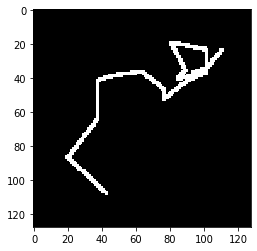

In [8]:
plt.imshow(dataset[0].to("cpu").reshape(128, 128), cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')

In [9]:
z_dim = 4
model_name = "DenseVAE_" + str(z_dim)+ "dim"
img_size = 128
model = DenseVAE_2dim(img_size, z_dim=z_dim).to(device)
print(model)

DenseVAE_2dim(
  (linear1): Linear(in_features=16384, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=16, bias=True)
  (linear_mean): Linear(in_features=16, out_features=4, bias=True)
  (linear_logvar): Linear(in_features=16, out_features=4, bias=True)
  (dec_linear6): Linear(in_features=4, out_features=16, bias=True)
  (dec_linear5): Linear(in_features=16, out_features=64, bias=True)
  (dec_linear4): Linear(in_features=64, out_features=256, bias=True)
  (dec_linear3): Linear(in_features=256, out_features=1024, bias=True)
  (dec_linear2): Linear(in_features=1024, out_features=4096, bias=True)
  (dec_linear1): Linear(in_features=4096, out_features=16384, bias=True)
)


In [10]:
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
# criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [12]:
num_save = 400
num_epochs = 1
train_ls = []

### 訓練

モデルの保存はCPUへ

In [13]:
for n in range(num_save):
    if n == 350 :
        optimizer.defaults["lr"] = 0.0005
    if n == 375:
        optimizer.defaults["lr"] = 0.0001
    for epoch in range(num_epochs):
        
        t1 = time.time()
        loss_sum = 0.0
        for i, batch_imgs in enumerate(dataloader):
            optimizer.zero_grad()
            reconstructed_imgs, mu, logvar = model(batch_imgs.to(device))
            loss = loss_function(reconstructed_imgs, batch_imgs.to(device), mu, logvar)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        t2 = time.time()
        train_ls.append(loss_sum)

        print("epoch --- %d train_loss: %.3f (train time: %.1f s = %.1f min)" %(n * num_epochs + epoch + 1, loss_sum, t2 - t1, (t2 - t1) / 60))
    torch.save(model.state_dict(), "../model_pths/" + model_name + ".pth")

epoch --- 1 train_loss: 58147454.156 (train time: 13.6 s = 0.2 min)
epoch --- 2 train_loss: 51469940.672 (train time: 12.7 s = 0.2 min)
epoch --- 3 train_loss: 50669575.875 (train time: 12.4 s = 0.2 min)
epoch --- 4 train_loss: 50362972.188 (train time: 12.5 s = 0.2 min)
epoch --- 5 train_loss: 50110931.719 (train time: 12.7 s = 0.2 min)
epoch --- 6 train_loss: 49726281.906 (train time: 12.6 s = 0.2 min)
epoch --- 7 train_loss: 49503350.562 (train time: 12.4 s = 0.2 min)
epoch --- 8 train_loss: 49208380.766 (train time: 12.5 s = 0.2 min)
epoch --- 9 train_loss: 48773093.828 (train time: 12.6 s = 0.2 min)
epoch --- 10 train_loss: 48333142.656 (train time: 12.6 s = 0.2 min)
epoch --- 11 train_loss: 48068923.703 (train time: 12.5 s = 0.2 min)
epoch --- 12 train_loss: 47836011.016 (train time: 12.4 s = 0.2 min)
epoch --- 13 train_loss: 47612629.594 (train time: 12.6 s = 0.2 min)
epoch --- 14 train_loss: 47377262.859 (train time: 12.6 s = 0.2 min)
epoch --- 15 train_loss: 47194158.016 (trai

epoch --- 120 train_loss: 31889099.578 (train time: 12.8 s = 0.2 min)
epoch --- 121 train_loss: 32232317.062 (train time: 12.6 s = 0.2 min)
epoch --- 122 train_loss: 31925263.000 (train time: 12.4 s = 0.2 min)
epoch --- 123 train_loss: 31689913.438 (train time: 18.3 s = 0.3 min)
epoch --- 124 train_loss: 31864361.094 (train time: 23.2 s = 0.4 min)
epoch --- 125 train_loss: 31866240.078 (train time: 22.3 s = 0.4 min)
epoch --- 126 train_loss: 31614381.438 (train time: 12.6 s = 0.2 min)
epoch --- 127 train_loss: 31497937.219 (train time: 12.7 s = 0.2 min)
epoch --- 128 train_loss: 31633344.250 (train time: 12.6 s = 0.2 min)
epoch --- 129 train_loss: 31503204.609 (train time: 12.4 s = 0.2 min)
epoch --- 130 train_loss: 31357739.859 (train time: 12.5 s = 0.2 min)
epoch --- 131 train_loss: 31502779.297 (train time: 12.7 s = 0.2 min)
epoch --- 132 train_loss: 31446221.078 (train time: 12.7 s = 0.2 min)
epoch --- 133 train_loss: 31263136.141 (train time: 12.5 s = 0.2 min)
epoch --- 134 train_

epoch --- 238 train_loss: 28331284.547 (train time: 12.7 s = 0.2 min)
epoch --- 239 train_loss: 28112097.180 (train time: 12.6 s = 0.2 min)
epoch --- 240 train_loss: 28482123.953 (train time: 12.5 s = 0.2 min)
epoch --- 241 train_loss: 28433360.734 (train time: 12.6 s = 0.2 min)
epoch --- 242 train_loss: 28415187.578 (train time: 12.7 s = 0.2 min)
epoch --- 243 train_loss: 28628222.391 (train time: 12.6 s = 0.2 min)
epoch --- 244 train_loss: 28243906.820 (train time: 12.5 s = 0.2 min)
epoch --- 245 train_loss: 28524341.320 (train time: 12.5 s = 0.2 min)
epoch --- 246 train_loss: 28172918.023 (train time: 12.7 s = 0.2 min)
epoch --- 247 train_loss: 28139680.602 (train time: 12.7 s = 0.2 min)
epoch --- 248 train_loss: 27918775.727 (train time: 12.5 s = 0.2 min)
epoch --- 249 train_loss: 28351815.664 (train time: 12.4 s = 0.2 min)
epoch --- 250 train_loss: 28106161.039 (train time: 12.6 s = 0.2 min)
epoch --- 251 train_loss: 28183868.617 (train time: 12.7 s = 0.2 min)
epoch --- 252 train_

epoch --- 356 train_loss: 26606862.289 (train time: 12.5 s = 0.2 min)
epoch --- 357 train_loss: 26778017.953 (train time: 12.4 s = 0.2 min)
epoch --- 358 train_loss: 26624657.133 (train time: 12.5 s = 0.2 min)
epoch --- 359 train_loss: 27019458.156 (train time: 12.5 s = 0.2 min)
epoch --- 360 train_loss: 26505104.695 (train time: 12.6 s = 0.2 min)
epoch --- 361 train_loss: 26412705.477 (train time: 12.6 s = 0.2 min)
epoch --- 362 train_loss: 26574596.461 (train time: 12.6 s = 0.2 min)
epoch --- 363 train_loss: 26750695.906 (train time: 12.6 s = 0.2 min)
epoch --- 364 train_loss: 26687544.633 (train time: 12.4 s = 0.2 min)
epoch --- 365 train_loss: 26697315.141 (train time: 12.4 s = 0.2 min)
epoch --- 366 train_loss: 27211177.406 (train time: 12.5 s = 0.2 min)
epoch --- 367 train_loss: 26719533.812 (train time: 12.6 s = 0.2 min)
epoch --- 368 train_loss: 26777912.164 (train time: 12.6 s = 0.2 min)
epoch --- 369 train_loss: 26396904.383 (train time: 12.6 s = 0.2 min)
epoch --- 370 train_

In [14]:
def plot_results(result, which_result, condition, save_or_not=True):
    plt.clf()
    plt.plot(result)
    plt.title(condition + "_" + which_result)
    plt.savefig(condition + "_" + which_result + ".png") if save_or_not else plt.show()

In [15]:
loss_img_path = "../loss_imgs/"
condition = "DenseVAE_128to" + str(z_dim)

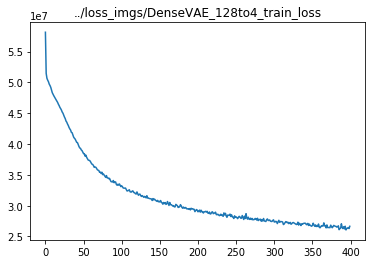

In [16]:
plot_results(train_ls, "train_loss", loss_img_path + condition)

In [17]:
poses = [1000,2000,3000,4000,5000,6000]

<Figure size 432x288 with 0 Axes>

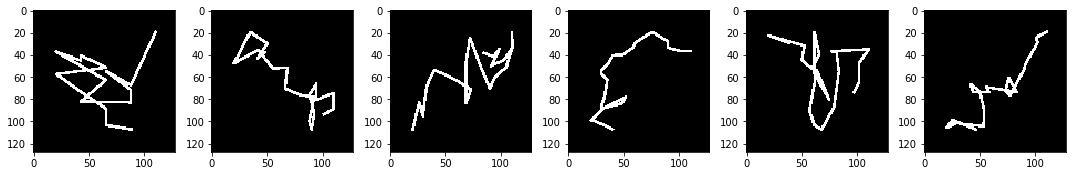

In [18]:
imshow_dense(dataset, poses)

<Figure size 432x288 with 0 Axes>

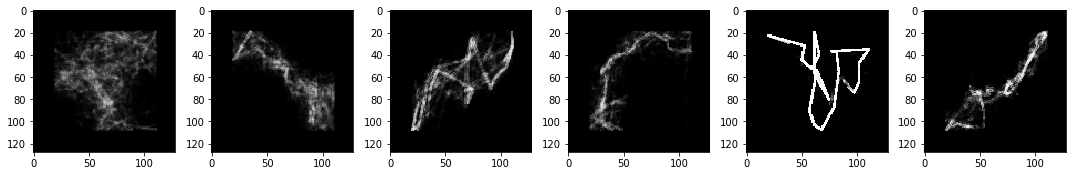

In [20]:
imshow_dense(dataset, poses, model=model, device=device)

In [ ]:
orig_hidden_vecs = []
orig_hidden_mus = []
with torch.no_grad():
    for i, (date, batch_imgs) in enumerate(zip(dates, dataloader1)):
        mu, logvar = model.encoder(batch_imgs)
        orig_hidden_mus.append(mu.to("cpu").numpy())
        z = model.reparameterize(mu, logvar)
        z = z.to("cpu").numpy()
        orig_hidden_vecs.append(z)
orig_hidden_vecs = np.array(orig_hidden_vecs)
orig_hidden_mus = np.array(orig_hidden_mus)

In [ ]:
hidden_vecs = orig_hidden_vecs.reshape(19154, z_dim)
hidden_mus = orig_hidden_mus.reshape(19154, z_dim)
print(hidden_vecs.shape)
print(hidden_mus.shape)

In [ ]:
with open(data_pkls + "hidden_vecs_densevaedim" + str(z_dim) + ".pkl", "wb") as f:
    pickle.dump(hidden_vecs, f)
with open(data_pkls + "hidden_mus_densevaedim" + str(z_dim) + ".pkl", "wb") as f:
    pickle.dump(hidden_mus, f)